In [169]:
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

Mode = 'Pred'
point = 600
by_day = False
random_val = False

sunshine = pd.read_csv("Dataset/sunshine.csv")
temp = pd.read_csv("Dataset/temp.csv")
wind = pd.read_csv("Dataset/wind.csv")

# sunshine['Radiation'] = np.log1p(sunshine['Radiation'])

if random_val:
    data = sunshine.merge(temp, on=['Day', 'Hour'], how='left').merge(wind, on=['Day', 'Hour'], how='left')
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
else:
    train_data = sunshine[0:-point].merge(temp, on=['Day', 'Hour'], how='left')
    train_data = train_data.merge(wind, on=['Day', 'Hour'], how='left')
    val_data = sunshine[4500-point:].merge(temp, on=['Day', 'Hour'], how='left')
    val_data = val_data.merge(wind, on=['Day', 'Hour'], how='left')

if Mode == 'Train':
    pre_data = val_data.copy()

elif Mode == 'Pred':
    sunshine1 = sunshine.iloc[0:150, :]
    sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)
    pre_data = sunshine1.merge(temp, on=['Day', 'Hour'], how='left')
    pre_data = pre_data.merge(wind, on=['Day', 'Hour'], how='left')
    pre_data['Radiation'] = 0

Temp_day = train_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
train_data = train_data.merge(Temp_day, on=['Day'], how='left')

Temp_day = val_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
val_data = val_data.merge(Temp_day, on=['Day'], how='left')

Temp_day = pre_data.groupby(['Day'])['Temp'].mean().to_frame('Temp_day').reset_index()
Temp_day['Diff_Temp'] = Temp_day['Temp_day'].diff()
pre_data = pre_data.merge(Temp_day, on=['Day'], how='left')

if by_day:
    train_data = train_data.groupby(['Day']).mean().reset_index()
    val_data = val_data.groupby(['Day']).mean().reset_index()
    pre_data = pre_data.groupby(['Day']).mean().reset_index()
    
features = [f for f in train_data.columns if f not in ['Radiation', 'day_t']]

dtrain = xgb.DMatrix(train_data[features], label=train_data['Radiation'].values)
dtest = xgb.DMatrix(pre_data[features], label=pre_data['Radiation'].values)

# specify parameters via map
param = {'max_depth':7, 'eta':0.3, 'objective':'reg:squarederror', 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'lambda': 0.1}
num_round = 10
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

/tmp/ipykernel_35903/3980279878.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunshine1['Day'] = sunshine1['Day'].map(lambda x: x + 300)


0.0810906570110594

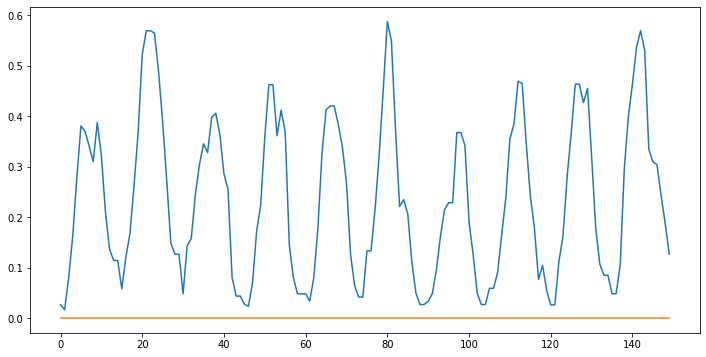

In [170]:
# preds = np.expm1(preds)
# pre_data['Radiation'] = np.expm1(pre_data['Radiation'])

plt.figure(figsize=(12, 6))
plt.plot(preds)
plt.plot(pre_data['Radiation'])
# plt.plot(val_data['Temp'])
# plt.plot(val_data['Spd'])
# plt.plot(val_data['Dir'])

from sklearn.metrics import mean_squared_error
mean_squared_error(pre_data['Radiation'], preds)

In [171]:
dataframe = pd.DataFrame({'Radiation': preds})
dataframe.to_csv("Dataset/Y_pred.csv", index=False, sep=',')